In [198]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [8]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Read first_row for Measurement 
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237bb95c490>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 18.3,
 'prcp': 2.0,
 'id': 0}

In [139]:
# Read first_row for Station 
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237b6b3be20>,
 'id': 0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 0.914}

In [200]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [214]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime.strptime(most_recent_date.date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago

datetime.datetime(2016, 8, 23, 0, 0)

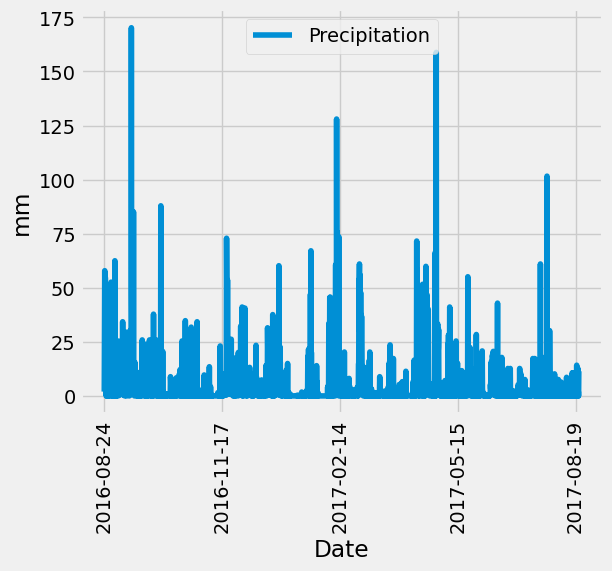

In [216]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
        .filter(Measurement.prcp.isnot(None))\
            .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_data_sorted_df = precipitation_data_df.set_index('Date').sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_sorted_df.plot(figsize=(6,5), rot=90)
plt.ylabel('mm')
plt.legend(loc='upper center')
plt.show()

In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data_sorted_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [148]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [149]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [166]:
most_active_station_id = most_active_stations[0][0]
most_active_station_id

'USC00519281'

In [168]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs_most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id).all()
tobs_most_active

[(12.2, 29.4, 22.03582251082252)]

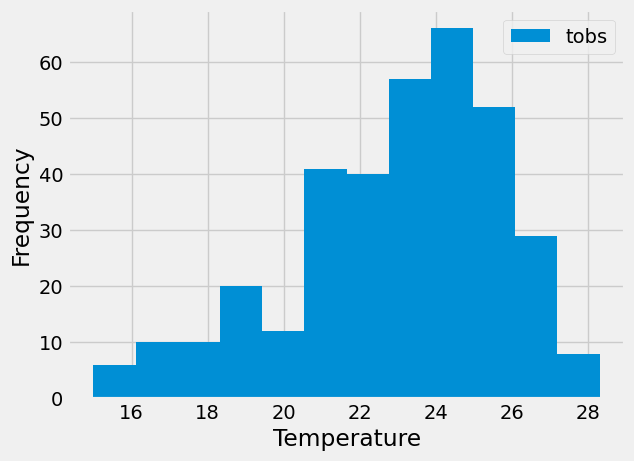

In [217]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date >= one_year_ago)\
        .filter(Measurement.station == most_active_station_id).all()

tobs_data_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

plt.hist(tobs_data_df['Temperature'], bins=12)
plt.legend(labels = ['tobs'], loc='upper right')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [197]:
# Close Session
session.close()
